**Tratamento dos dados**


In [140]:
!pip -q install plotly --upgrade

**Importando bibliotecas**

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

**Abrindo um arquivo CSV do drive**

In [142]:
base = pd.read_csv('train.csv', sep=',')

In [143]:
base = base.drop(columns=["Name", "Ticket", "PassengerId"])

In [144]:
base.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


**Contando quantidade de instâncias**


In [145]:
Classificação = base["Survived"]
np.unique(Classificação, return_counts=True)

(array([0, 1]), array([815, 494]))

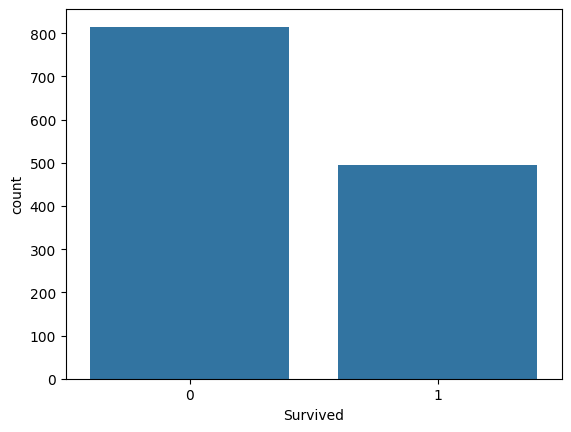

In [146]:
sns.countplot(x = Classificação);

**Tratamento de dados categóricos**

In [147]:
from sklearn.preprocessing import LabelEncoder
#para codificar todos os atributos para laberEncoder de uma única vez
#base_encoded = base.apply(LabelEncoder().fit_transform)
cols_label_encode = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
base[cols_label_encode] = base[cols_label_encode].apply(LabelEncoder().fit_transform)

base["Cabin"] = base["Cabin"].notna().astype(int)


**Contando quantas opções de resposta tem cada atributo**

In [148]:
len(np.unique(base['SibSp']))

7

In [149]:
from sklearn.preprocessing import OneHotEncoder
cols_onehot_encode = []
# Inicializar o OneHotEncoder (sparse_output=False retorna um array denso)
onehot = OneHotEncoder(sparse_output=False)

# Aplicar o OneHotEncoder apenas nas colunas categóricas
df_onehot = onehot.fit_transform(base[cols_onehot_encode])

# Obter os novos nomes das colunas após a codificação
nomes_das_colunas = onehot.get_feature_names_out(cols_onehot_encode)

# Criar um DataFrame com os dados codificados e as novas colunas
df_onehot = pd.DataFrame(df_onehot, columns=nomes_das_colunas)

# Combinar as colunas codificadas com as colunas que não foram transformadas
base_encoded= pd.concat([df_onehot, base.drop(columns=cols_onehot_encode)], axis=1)

import numpy as np

# faixas de 10 em 10 anos
min_age = int(base_encoded['Age'].min())
max_age = int(base_encoded['Age'].max()) + 10  # garantir que o máximo esteja incluído

bins = list(range(0, max_age + 1, 10))
labels = list(range(1, len(bins)))

# Preencher NaNs antes de cortar
base_encoded['Age'] = base_encoded['Age'].fillna(base_encoded['Age'].median())

# Criar faixas
base_encoded['Age'] = pd.cut(base_encoded['Age'], bins=bins, labels=labels, right=True).astype(int)

base_encoded['Fare'] = base_encoded['Fare'].fillna(base_encoded['Fare'].median())

# Determinar mínimo e máximo da Fare
min_fare = int(base_encoded['Fare'].min())
max_fare = int(base_encoded['Fare'].max()) + 10 # garante que o máximo caia no último bin

# Criar bins de 100 em 100
bins = list(range(0, max_fare + 1, 10))
labels = list(range(1, len(bins)))

# Criar faixas
base_encoded['Fare'] = pd.cut(base_encoded['Fare'], bins=bins, labels=labels, right=True)

# Converter para inteiro permitindo NaNs (caso existam)
base_encoded['Fare'] = base_encoded['Fare'].astype('Int64')

In [150]:
base_encoded

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,2,1,3,1,0,1,0,2
1,1,0,0,4,1,0,8,1,0
2,1,2,0,3,0,0,1,0,2
3,1,0,0,4,1,0,6,1,2
4,0,2,1,4,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...
1304,0,2,1,3,0,0,1,0,2
1305,1,0,0,4,0,0,11,1,0
1306,0,2,1,4,0,0,1,0,2
1307,0,2,1,3,0,0,1,0,2


**Separar o dataset em variáveis independentes (X_prev) e dependentes (y_classe) fazer o mesmo com a base com dados continuos**

In [151]:
X_prev = base_encoded.drop(columns=["Survived"])
y_classe = base_encoded["Survived"]

X_prev_continuous = base.drop(columns=["Survived"])
y_classe_continuous = base["Survived"]


**Método de amostragem Holdout**

In [153]:
from sklearn.model_selection import train_test_split
#Um split de treino e teste para a base normal (atributos continuos) e uma para a encoded
X_treino, X_teste, y_treino, y_teste = train_test_split(X_prev, y_classe, test_size = 0.20, random_state = 42)
X_treino_continuous, X_teste_continuous, y_treino_continuous, y_teste_continuous = train_test_split(X_prev_continuous, y_classe_continuous, test_size = 0.20, random_state = 42)


**Métodos gerais**

In [154]:
from collections import Counter
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def information_gain(X_col, y):
    parent_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        y_child = y[X_col == v]
        weighted_entropy += (c / len(X_col)) * entropy(y_child)

    return parent_entropy - weighted_entropy

def split_info(X_col):
    values, counts = np.unique(X_col, return_counts=True)
    probs = counts / len(X_col)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def gain_ratio(X_col, y):
    gain = information_gain(X_col, y)
    si = split_info(X_col)
    return gain / si if si > 0 else 0

def gini(y):
    if len(y) == 0:
        return 0.0
    counts = np.bincount(y, minlength=(np.max(y)+1))
    probs = counts[counts > 0] / len(y)
    return 1.0 - np.sum(probs ** 2)

def gini_gain(parent_y, left_y, right_y):
    n = len(parent_y)
    if n == 0:
        return 0.0
    g_parent = gini(parent_y)
    nL, nR = len(left_y), len(right_y)
    if nL == 0 or nR == 0:
        return 0.0
    weighted = (nL / n) * gini(left_y) + (nR / n) * gini(right_y)
    return g_parent - weighted

**Implementações**

In [155]:
#ID3
def best_split(X, y):
    gains = [information_gain(X[:, i], y) for i in range(X.shape[1])]
    return np.argmax(gains), np.max(gains)

class Node:
    def __init__(self, feature=None, value=None, children=None, label=None):
        self.feature = feature
        self.value = value
        self.children = children
        self.label = label

def id3(X, y, feature_names):
    if len(set(y)) == 1:
        return Node(label=y[0])
    if X.shape[1] == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        return Node(label=majority_class)

    best_feat, best_gain = best_split(X, y)
    if best_gain == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        return Node(label=majority_class)

    node = Node(feature=feature_names[best_feat], children={})
    values = np.unique(X[:, best_feat])
    for v in values:
        mask = X[:, best_feat] == v
        X_child = np.delete(X[mask], best_feat, axis=1)
        y_child = y[mask]
        new_features = [f for i, f in enumerate(feature_names) if i != best_feat]
        node.children[v] = id3(X_child, y_child, new_features)

    return node

def print_tree(node, depth=0):
    indent = "  " * depth
    if node.label is not None:
        print(f"{indent}--> Classe: {node.label}")
    else:
        print(f"{indent}[Atributo: {node.feature}]")
        for v, child in node.children.items():
            print(f"{indent}  Valor = {v}:")
            print_tree(child, depth + 2)

In [156]:
#C4.5
def best_split_c45(X, y, feature_names):
    best_feature = None
    best_threshold = None
    best_gain_ratio = -1
    is_continuous = False

    for i, feat in enumerate(feature_names):
        col = X[:, i]

        # Caso contínuo (float ou muitos valores distintos)
        if np.issubdtype(col.dtype, np.number) and len(np.unique(col)) > 10:
            thresholds = np.unique(col)
            for t in thresholds:
                left_mask = col <= t
                right_mask = col > t

                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]

                parent_entropy = entropy(y)
                weighted_entropy = (len(y_left)/len(y)) * entropy(y_left) + (len(y_right)/len(y)) * entropy(y_right)
                gain = parent_entropy - weighted_entropy

                splitinfo = split_info(np.array(["L"]*len(y_left) + ["R"]*len(y_right)))
                gr = gain / splitinfo if splitinfo > 0 else 0

                if gr > best_gain_ratio:
                    best_gain_ratio = gr
                    best_feature = feat
                    best_threshold = t
                    is_continuous = True

        else:
            # Caso categórico
            gr = gain_ratio(col, y)
            if gr > best_gain_ratio:
                best_gain_ratio = gr
                best_feature = feat
                best_threshold = None
                is_continuous = False

    return best_feature, best_threshold, best_gain_ratio, is_continuous

class NodeC45:
    def __init__(self, feature=None, threshold=None, children=None, label=None, is_continuous=False):
        self.feature = feature
        self.threshold = threshold
        self.children = children
        self.label = label
        self.is_continuous = is_continuous

def c45(X, y, feature_names):
    if len(set(y)) == 1:
        return NodeC45(label=y[0])
    if X.shape[1] == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        return NodeC45(label=majority_class)

    best_feat, best_thr, best_gr, is_continuous = best_split_c45(X, y, feature_names)
    if best_gr == 0:
        majority_class = Counter(y).most_common(1)[0][0]
        return NodeC45(label=majority_class)

    node = NodeC45(feature=best_feat, threshold=best_thr, children={}, is_continuous=is_continuous)

    feat_index = feature_names.index(best_feat)

    if is_continuous:
        left_mask = X[:, feat_index] <= best_thr
        right_mask = X[:, feat_index] > best_thr
        node.children["<=%.2f" % best_thr] = c45(X[left_mask], y[left_mask], feature_names)
        node.children[">%.2f" % best_thr] = c45(X[right_mask], y[right_mask], feature_names)
    else:
        values = np.unique(X[:, feat_index])
        for v in values:
            mask = X[:, feat_index] == v
            X_child = np.delete(X[mask], feat_index, axis=1)
            y_child = y[mask]
            new_features = [f for i, f in enumerate(feature_names) if i != feat_index]
            node.children[v] = c45(X_child, y_child, new_features)

    return node

def print_tree_c45(node, depth=0):
    indent = "  " * depth
    if node.label is not None:
        print(f"{indent}--> Classe: {node.label}")
    else:
        if node.is_continuous:
            print(f"{indent}[Atributo contínuo: {node.feature}]")
        else:
            print(f"{indent}[Atributo categórico: {node.feature}]")
        for v, child in node.children.items():
            print(f"{indent}  Valor/Condição = {v}:")
            print_tree_c45(child, depth + 2)

In [157]:
#CART
class NodeCART:
    def __init__(self,
                 feature_index=None,
                 feature_name=None,
                 threshold=None,
                 category=None,
                 is_categorical=False,
                 left=None,
                 right=None,
                 label=None,
                 depth=0):
        self.feature_index = feature_index
        self.feature_name = feature_name
        self.threshold = threshold        # usado para numéricos
        self.category = category          # usado para categóricos
        self.is_categorical = is_categorical
        self.left = left
        self.right = right
        self.label = label
        self.depth = depth

def best_split_cart(X, y, feature_names):
    n_features = X.shape[1]
    best_gain = -1.0
    best_idx = None
    best_name = None
    best_is_cat = False
    best_threshold = None
    best_category = None

    for j in range(n_features):
        col = X[:, j]
        name = feature_names[j]

        # Heurística para detectar categórico vs numérico
        # Considerar dtype não numérico ou poucos valores únicos como categórico
        unique_vals = np.unique(col)
        is_numeric = np.issubdtype(col.dtype, np.number)

        # Se numérico com muitos valores distintos, tratar como contínuo
        if is_numeric and len(unique_vals) > 10:
            # thresholds como pontos médios entre únicos ordenados
            unique_vals_sorted = np.sort(unique_vals)
            candidates = (unique_vals_sorted[:-1] + unique_vals_sorted[1:]) / 2.0
            for t in candidates:
                left_mask = col <= t
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gain = gini_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_idx = j
                    best_name = name
                    best_is_cat = False
                    best_threshold = float(t)
                    best_category = None

        else:
            # Categórico (ou numérico com poucos valores, tratado como rótulos)
            for v in unique_vals:
                left_mask = (col == v)
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gain = gini_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_idx = j
                    best_name = name
                    best_is_cat = True
                    best_threshold = None
                    best_category = v

    return best_idx, best_name, best_is_cat, best_threshold, best_category, best_gain


def cart_train(
    X, y, feature_names,
    max_depth=None,
    min_samples_split=2,
    min_impurity_decrease=0.0,
    depth=0
):
    # Nó folha por pureza
    if len(np.unique(y)) == 1:
        return NodeCART(label=int(y[0]), depth=depth)

    # Parada por profundidade
    if max_depth is not None and depth >= max_depth:
        majority = Counter(y).most_common(1)[0][0]
        return NodeCART(label=int(majority), depth=depth)

    # Parada por tamanho mínimo
    if len(y) < min_samples_split:
        majority = Counter(y).most_common(1)[0][0]
        return NodeCART(label=int(majority), depth=depth)

    # Melhor split
    best = best_split_cart(X, y, feature_names)
    (best_idx, best_name, is_cat, thr, cat, best_gain) = best

    # Parada por ganho mínimo
    if best_idx is None or best_gain <= min_impurity_decrease:
        majority = Counter(y).most_common(1)[0][0]
        return NodeCART(label=int(majority), depth=depth)

    # Aplicar split
    col = X[:, best_idx]
    if is_cat:
        left_mask = (col == cat)
        cond_str = f"== {cat}"
    else:
        left_mask = (col <= thr)
        cond_str = f"<= {thr:.6f}"
    right_mask = ~left_mask

    left_child = cart_train(
        X[left_mask], y[left_mask], feature_names,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_impurity_decrease=min_impurity_decrease,
        depth=depth+1
    )
    right_child = cart_train(
        X[right_mask], y[right_mask], feature_names,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_impurity_decrease=min_impurity_decrease,
        depth=depth+1
    )

    node = NodeCART(
        feature_index=best_idx,
        feature_name=best_name,
        threshold=thr,
        category=cat,
        is_categorical=is_cat,
        left=left_child,
        right=right_child,
        label=None,
        depth=depth
    )
    return node

def cart_predict_row(x_row, node: NodeCART):
    cur = node
    while cur.label is None:
        val = x_row[cur.feature_index]
        if cur.is_categorical:
            go_left = (val == cur.category)
        else:
            go_left = (val <= cur.threshold)
        cur = cur.left if go_left else cur.right
    return cur.label

def cart_predict(X, tree: NodeCART):
    preds = [cart_predict_row(x, tree) for x in X]
    return np.array(preds, dtype=int)

def print_tree_cart(node: NodeCART, indent=""):
    if node.label is not None:
        print(f"{indent}--> Classe: {node.label}")
        return
    if node.is_categorical:
        cond = f"{node.feature_name} == {node.category}"
    else:
        cond = f"{node.feature_name} <= {node.threshold:.6f}"
    print(f"{indent}[Split: {cond}]")
    print(f"{indent}  (Left)")
    print_tree_cart(node.left, indent + "    ")
    print(f"{indent}  (Right)")
    print_tree_cart(node.right, indent + "    ")

**Prints**

In [158]:
#Print ID3
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def predict_single(x, node, feature_names):
    if node.label is not None:
        return node.label
    else:
        feat_index = feature_names.index(node.feature)
        value = x[feat_index]

        if value in node.children:
            return predict_single(x, node.children[value], feature_names)
        else:
            labels = []
            for child in node.children.values():
                if child.label is not None:
                    labels.append(child.label)
            if labels:
                return Counter(labels).most_common(1)[0][0]
            else:
                return 0
            

def predict(X, tree, feature_names):
    return np.array([predict_single(row, tree, feature_names) for row in X])

X_train_fixed = X_treino.fillna(-1).astype(int).values
y_train_fixed = y_treino.fillna(-1).astype(int).values.ravel()

X_test_fixed = X_teste.fillna(-1).astype(int).values
y_test_fixed = y_teste.fillna(-1).astype(int).values.ravel()

features = list(X_treino.columns)

tree = id3(X_train_fixed, y_train_fixed, features)

print("Árvore ID3:")
print_tree(tree)

y_pred_id3 = predict(X_test_fixed, tree, features)

print("\n--- Avaliação ID3 ---")
print("Acurácia:", accuracy_score(y_test_fixed, y_pred_id3))
print("Matriz de confusão:\n", confusion_matrix(y_test_fixed, y_pred_id3))
print("Relatório de classificação:\n", classification_report(y_test_fixed, y_pred_id3))


Árvore ID3:
[Atributo: Sex]
  Valor = 0:
    [Atributo: Pclass]
      Valor = 0:
        [Atributo: Fare]
          Valor = 3:
            [Atributo: Age]
              Valor = 2:
                --> Classe: 1
              Valor = 3:
                --> Classe: 1
              Valor = 4:
                --> Classe: 1
              Valor = 5:
                [Atributo: Embarked]
                  Valor = 0:
                    --> Classe: 1
                  Valor = 2:
                    --> Classe: 1
              Valor = 6:
                --> Classe: 1
              Valor = 7:
                --> Classe: 1
          Valor = 4:
            --> Classe: 1
          Valor = 5:
            --> Classe: 1
          Valor = 6:
            --> Classe: 1
          Valor = 7:
            --> Classe: 1
          Valor = 8:
            --> Classe: 1
          Valor = 9:
            --> Classe: 1
          Valor = 10:
            --> Classe: 1
          Valor = 11:
            --> Classe: 1
    

In [159]:
# Print C4.5
# Usa os atributos continuos
X_train_continuous_fixed = X_treino_continuous.to_numpy(dtype=float)
y_train_continuous_fixed = y_treino_continuous.fillna(-1).astype(int).values.ravel()

X_test_continuous_fixed  = X_teste_continuous.to_numpy(dtype=float)
y_test_continuous_fixed  = y_teste_continuous.fillna(-1).astype(int).values.ravel()

features_continuous = list(X_treino_continuous.columns)

tree = c45(X_train_continuous_fixed, y_train_continuous_fixed, features_continuous)

print("Árvore C4.5:")
print_tree(tree)

y_pred_c45 = predict(X_test_continuous_fixed, tree, features_continuous)

print("\n--- Avaliação C4.5 ---")
print("Acurácia:", accuracy_score(y_test_continuous_fixed, y_pred_c45))
print("Matriz de confusão:\n", confusion_matrix(y_test_continuous_fixed, y_pred_c45))
print("Relatório de classificação:\n", classification_report(y_test_continuous_fixed, y_pred_c45, zero_division=0))

Árvore C4.5:
[Atributo: Age]
  Valor = <=0.17:
    --> Classe: 1
  Valor = >0.17:
    [Atributo: Sex]
      Valor = 0.0:
        [Atributo: Fare]
          Valor = <=6.75:
            --> Classe: 0
          Valor = >6.75:
            [Atributo: Pclass]
              Valor = 0.0:
                [Atributo: Fare]
                  Valor = <=28.71:
                    [Atributo: Fare]
                      Valor = 25.7:
                        --> Classe: 1
                      Valor = 25.9292:
                        --> Classe: 1
                      Valor = 26.2833:
                        --> Classe: 1
                      Valor = 26.55:
                        --> Classe: 1
                      Valor = 27.4458:
                        --> Classe: 1
                      Valor = 27.7208:
                        --> Classe: 1
                      Valor = 28.7125:
                        --> Classe: 0
                  Valor = >28.71:
                    [Atributo: Fare]
         

In [160]:
# Print CART
tree_cart = cart_train(
    X_train_fixed, y_train_fixed, features,
    max_depth=None,  
    min_samples_split=2,  
    min_impurity_decrease=0.0
)

print("Árvore CART:")
print_tree_cart(tree_cart)

y_pred_cart = cart_predict(X_test_fixed, tree_cart)

print("\n--- Avaliação CART ---")
print("Acurácia:", accuracy_score(y_test_fixed, y_pred_cart))
print("Matriz de confusão:\n", confusion_matrix(y_test_fixed, y_pred_cart))
print("Relatório de classificação:\n", classification_report(y_test_fixed, y_pred_cart))

Árvore CART:
[Split: Sex == 0]
  (Left)
    [Split: Pclass == 2]
      (Left)
        [Split: Fare == 4]
          (Left)
            [Split: Age == 4]
              (Left)
                --> Classe: 1
              (Right)
                [Split: Parch == 0]
                  (Left)
                    --> Classe: 1
                  (Right)
                    --> Classe: 0
          (Right)
            [Split: SibSp == 3]
              (Left)
                [Split: Age == 4]
                  (Left)
                    --> Classe: 1
                  (Right)
                    --> Classe: 0
              (Right)
                [Split: Age == 5]
                  (Left)
                    [Split: Parch == 0]
                      (Left)
                        [Split: Embarked == 0]
                          (Left)
                            --> Classe: 1
                          (Right)
                            [Split: SibSp == 0]
                              (Left)
     